Reconstruction Error for Ensemble Predictions: 0.000420


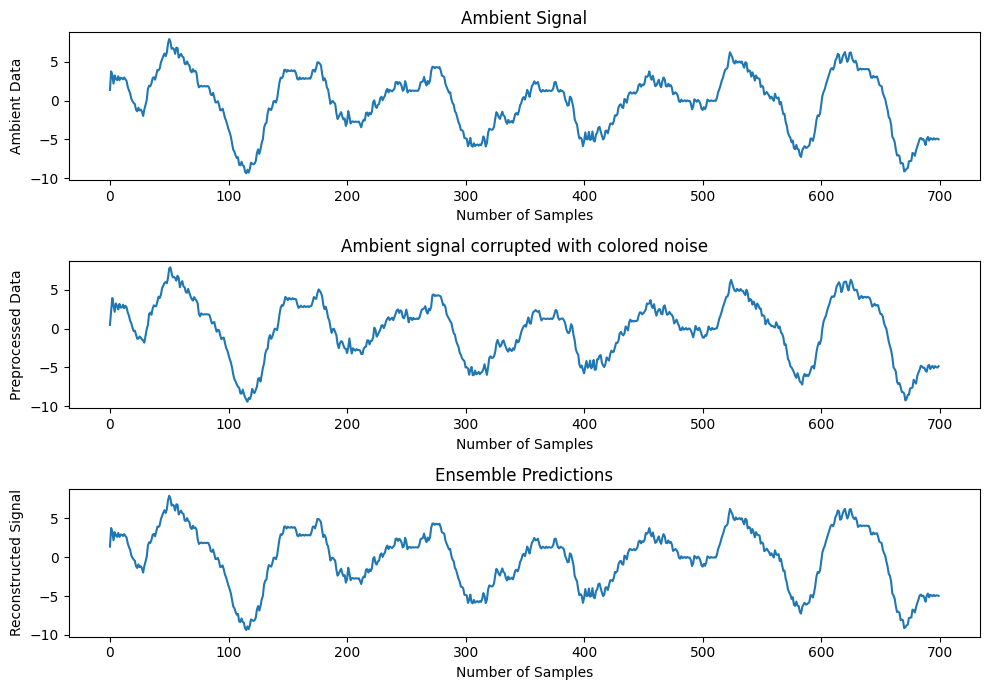

In [ ]:
import numpy as np
from scipy.io import loadmat, savemat
from scipy.signal import butter, lfilter
from sklearn.decomposition import NMF, FastICA, SparsePCA
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Load data
data = loadmat('colored_signal_w2.mat')
x_sig = data['colored_signal_w2'].flatten()  # Original noise signal
fs = 10  # Sampling frequency
cf = fs / 2.5  # Cutoff frequency

# Apply colored noise
B, A = butter(5, 2 * cf / fs)
x_colored = lfilter(B, A, x_sig)  # Signal corrupted with colored noise

# Combine the signals for NMF
X_nmf = np.vstack((x_sig, x_colored)).T  # Combine signals

# Combine the signals for ICA
X_ica = np.vstack((x_sig, x_colored)).T  # Combine signals

# Add a small positive constant to ensure non-negativity for NMF
X_nmf = X_nmf + np.abs(np.min(X_nmf)) + 1e-10

# Perform Non-negative Matrix Factorization (NMF) with multiple iterations
num_sources = 2
num_iterations_nmf = 5
ensemble_nmf_results = []

for i in range(num_iterations_nmf):
    nmf = NMF(n_components=num_sources, init='random', random_state=i)
    W = nmf.fit_transform(X_nmf)
    H = nmf.components_
    reconstructed_signal = W[:, 0]
    ensemble_nmf_results.append(reconstructed_signal)

# Perform Independent Component Analysis (ICA) with multiple iterations
num_iterations_ica = 5
ensemble_ica_results = []

for i in range(num_iterations_ica):
    ica = FastICA(n_components=num_sources, random_state=i)
    S_ = ica.fit_transform(X_ica)
    reconstructed_signal_ica = S_[:, 0]
    ensemble_ica_results.append(reconstructed_signal_ica)

# Apply Sparse PCA for noise reduction
num_components = 1  # Number of components to extract
spca = SparsePCA(n_components=num_components, alpha=0.1)  # Adjust alpha as needed
spca_components = spca.fit_transform(x_colored.reshape(-1, 1))
x_denoised = np.dot(spca_components, spca.components_).flatten()

# Combine results from NMF, ICA, and Sparse PCA
ensemble_stacked_results = np.vstack((ensemble_nmf_results, ensemble_ica_results, x_denoised)).T

# Use ensemble_stacked_results for training a regression model (e.g., RandomForestRegressor and XGBoost)
regressor_rf = RandomForestRegressor()
regressor_xgb = xgb.XGBRegressor()

# Train RandomForestRegressor
regressor_rf.fit(ensemble_stacked_results, x_sig)

# Train XGBoost
# Train XGBoost
regressor_xgb.fit(x_colored.reshape(-1, 1), x_sig)


# Make predictions using both models
predictions_rf = regressor_rf.predict(ensemble_stacked_results)
predictions_xgb = regressor_xgb.predict(x_colored)

# Combine predictions from RandomForestRegressor and XGBoost
combined_predictions = np.vstack((predictions_rf, predictions_xgb)).T

# Train a linear regression model on the combined predictions
linear_regressor = LinearRegression()
linear_regressor.fit(combined_predictions, x_sig)

# Create the final ensemble using StackingRegressor
estimators = [('RandomForest', regressor_rf), ('XGBoost', regressor_xgb), ('LinearRegression', linear_regressor)]
ensemble = StackingRegressor(estimators=estimators, final_estimator=RandomForestRegressor())

# Fit the ensemble model on the combined predictions
ensemble.fit(combined_predictions, x_sig)

# Make predictions using the ensemble model
ensemble_predictions = ensemble.predict(combined_predictions)

# Calculate mean squared error for ensemble predictions
#mse_ensemble = mean_squared_error(x_sig, ensemble_predictions)
#print("Mean Squared Error for Ensemble Predictions:", mse_ensemble)
reconstruction_error_ensemble = np.linalg.norm(x_sig - ensemble_predictions) / np.linalg.norm(x_sig)
print(f'Reconstruction Error for Ensemble Predictions: {reconstruction_error_ensemble:.6f}')

#savemat('predictions.mat', {'ensemble_predictions': ensemble_predictions})

# Plot the original noise signal and the ensemble predictions (first 1000 samples)


plt.figure(figsize=(10, 7))

plt.subplot(3, 1, 1)
plt.plot(x_sig[:700])  # Plot the first 1000 samples
plt.title('Ambient Signal')
plt.xlabel('Number of Samples')
plt.ylabel('Ambient Data')

plt.subplot(3, 1, 2)
plt.plot(x_colored[:700])  # Plot the first 1000 samples
plt.title('Ambient signal corrupted with colored noise')
plt.xlabel('Number of Samples')
plt.ylabel('Preprocessed Data')

plt.subplot(3, 1, 3)
plt.plot(ensemble_predictions[:700])  # Plot the first 1000 samples
plt.title('Ensemble Predictions')
plt.xlabel('Number of Samples')
plt.ylabel('Reconstructed Signal')

plt.tight_layout()
plt.show()

